In [1]:
from numerapi import NumerAPI, utils
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

napi = NumerAPI()

In [99]:
query = '''query simpleRoundsRequest($my_round: Int!) {
  RoundDetails(roundNumber: $my_round, tournament:8) {
    roundNumber,
    totalAtStake,
    totalPayout,
    totalStakes,
    status,
    payoutFactor,
    openTime,
    models {
      modelName,
      selectedStakeValue,
    }    
  }
}'''

allRounds = []
stakedThreshold = 1
print('Loading data...')

for my_round in range(202, napi.get_current_round()):
    args = {'my_round':my_round}
    data = napi.raw_query(query, args)['data']['RoundDetails']
    
    staked_models = pd.DataFrame(data['models'])
    staked_models.selectedStakeValue = staked_models.selectedStakeValue.astype(float)
    staked_model_count = len(staked_models[staked_models.selectedStakeValue > stakedThreshold])
    data.update({'staked_model_count':staked_model_count})
    
    allRounds.append(data)

results = pd.DataFrame(allRounds)
modelNames = staked_models.modelName.values

Loading data...


In [142]:
df = results.copy()
df = df.drop(columns='models')

# consider resolved rounds only
df = df[df.status == 'resolved'] 

# payouts are added 4 weeks later, when the round is fully resolved
df['totalPayout_shifted'] = df['totalPayout'].shift(4).fillna(0)

# cumulative payout
df['cumPayout'] = df.totalPayout_shifted.cumsum()

# stake changes for each round
df['stakeDiff'] = df.totalAtStake - df.totalAtStake.shift(1).fillna(0)

#Total stake minus all payouts and starting stake
df['newInvestment'] = (df.stakeDiff - df.totalPayout_shifted)

# zero out the first rounds, because it may come from previous payouts not in the dataset
df.loc[:3, 'newInvestment'] = 0

# cumulative new investments
df['cum_newInvestment'] = df['newInvestment'].cumsum()

# Payout %
df['earnings'] = df.totalPayout / df.totalAtStake

# cut off first lines with no payout information
df = df[4:].reset_index(drop=True)

df

,openTime,payoutFactor,roundNumber,status,totalAtStake,totalPayout,totalStakes,staked_model_count,totalPayout_shifted,cumPayout,stakeDiff,newInvestment,cum_newInvestment,earnings
0,2020-04-04T18:00:00Z,1.000000000000000000,206,resolved,66488.432607,4584.898825,428,337,201.020765,201.020765,1194.032380,993.011615,993.011615,0.068958
1,2020-04-11T18:00:00Z,1.000000000000000000,207,resolved,68641.263470,5078.793113,446,345,788.982669,990.003434,2152.830863,1363.848194,2356.859809,0.073990
2,2020-04-18T18:00:00Z,1.000000000000000000,208,resolved,67739.860820,2287.715568,470,366,1183.109034,2173.112469,-901.402650,-2084.511684,272.348125,0.033772
3,2020-04-25T18:00:00Z,1.000000000000000000,209,resolved,78841.498598,3599.132906,481,372,5640.080335,7813.192804,11101.637778,5461.557443,5733.905568,0.045650
4,2020-05-02T18:00:00Z,1.000000000000000000,210,resolved,86648.823796,3794.812853,487,378,4584.898825,12398.091628,7807.325198,3222.426374,8956.331941,0.043795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2021-12-18T18:00:00Z,0.510515584062471208,295,resolved,588623.027829,2200.138383,3519,2380,13972.408867,422890.273628,11096.737058,-2875.671810,100438.353975,0.003738
90,2021-12-25T18:00:00Z,0.494333375533357680,296,resolved,607930.880612,5804.065173,3501,2354,14348.618609,437238.892237,19307.852783,4959.234174,105397.588149,0.009547
91,2022-01-01T18:00:00Z,0.483063863886585685,297,resolved,622616.611096,14172.381715,3691,2460,10325.229632,447564.121869,14685.730484,4360.500852,109758.089000,0.022763
92,2022-01-08T18:00:00Z,0.472411763661280267,298,resolved,636335.440878,12820.551083,3786,2481,11713.436655,459277.558524,13718.829782,2005.393127,111763.482127,0.020147


In [144]:
startRound = df.roundNumber.iloc[0]
startTime = df.openTime.iloc[0]

startStake = df.totalAtStake.iloc[0] 
endStake = df.totalAtStake.iloc[-1]
stakeChange = endStake - startStake

sumPayout = df.totalPayout_shifted.sum()
sumNew = df.newInvestment.sum()


print(f'Starting from r{startRound}, {startTime}')

print(f'Stake change: {stakeChange:0.0f} NMR')
print(f'All payouts: {sumPayout:0.0f} NMR')

print(f'Percentage of payouts in the stake increase: {sumPayout/stakeChange*100:0.2f}%')
print(f'Percentage of new investment in the stake increase: {sumNew/stakeChange*100:0.2f}%')
print(f'New NMR staked (not from payouts): {sumNew:0.0f} NMR, USD price (at $30): {(sumNew) * 30:0.0f} USD')
print(f'Median earning per round: {df.earnings.median()*100:0.2f}%')


Starting from r206, 2020-04-04T18:00:00Z
Stake change: 572130 NMR
All payouts: 461478 NMR
Percentage of payouts in the stake increase: 80.66%
Percentage of new investment in the stake increase: 19.55%
New NMR staked (not from payouts): 111847 NMR, USD price (at $30): 3355405 USD
Median earning per round: 1.86%


<AxesSubplot:xlabel='Round Number'>

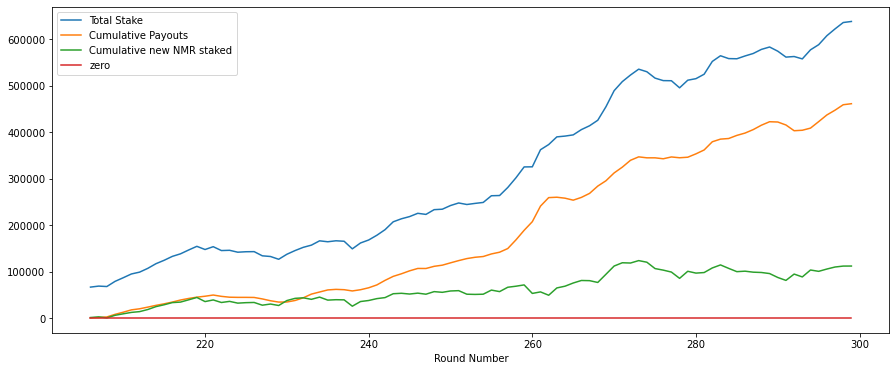

In [108]:
df['zero']=0
df.set_index('roundNumber')[['totalAtStake', 'cumPayout', 'cum_newInvestment', 'zero']].rename(columns = {'totalAtStake':'Total Stake',                                                                         
                                                                         'cumPayout': 'Cumulative Payouts',
                                                                         'cum_newInvestment':'Cumulative new NMR staked'}).plot(figsize=(15,6), xlabel='Round Number')

<AxesSubplot:xlabel='roundNumber'>

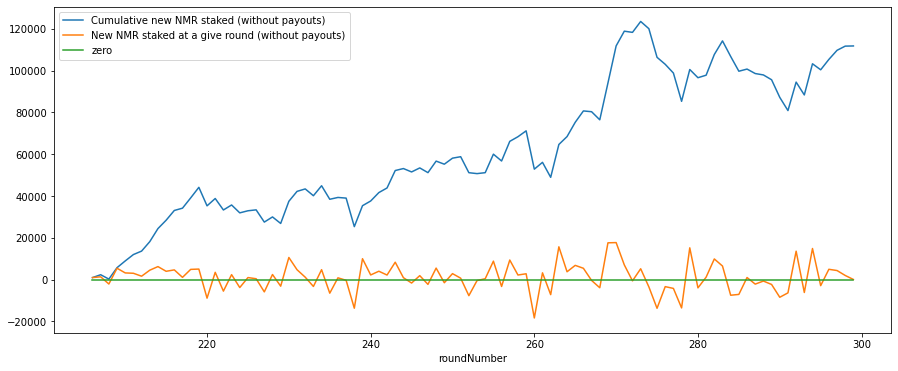

In [109]:
df.set_index('roundNumber')[['cum_newInvestment', 'newInvestment', 'zero']].rename(columns={'cum_newInvestment':'Cumulative new NMR staked (without payouts)',
                                                                   'newInvestment':'New NMR staked at a give round (without payouts)'}).plot(figsize=(15,6))

# Token supply

In [11]:
import requests
import json
url = 'https://numer.ai/nmr'
response = requests.get(url)

In [137]:
nmr =  json.loads(response.text)
circulating_supply = int(float(nmr['circulating_supply']['value']))
total_supply = int(float(nmr['total_supply']['value']))
current_stake_amount = int(float(nmr['current_stake_amount']['value']))
erasure_stake_amount = int(float(nmr['current_stake_amount_erasure']['value']))
numerai_stake_amount = current_stake_amount-erasure_stake_amount

print(f'Numerai Stake Amount: {numerai_stake_amount}')

print(f'Percentage of circulating supply at stake (all): {current_stake_amount / circulating_supply*100:0.2f}%')
print(f'Percentage of circulating supply at stake (Numerai): {numerai_stake_amount / circulating_supply*100:0.2f}%')

print(f'Percentage of circulating supply purchased for staking since r{startRound}: {sumNew/circulating_supply*100:0.2f}%')

Numerai Stake Amount: 768445
Percentage of circulating supply at stake (all): 17.66%
Percentage of circulating supply at stake (Numerai): 12.99%
Percentage of circulating supply purchased for staking since r206: 1.89%


# People at Numerai

<AxesSubplot:xlabel='roundNumber'>

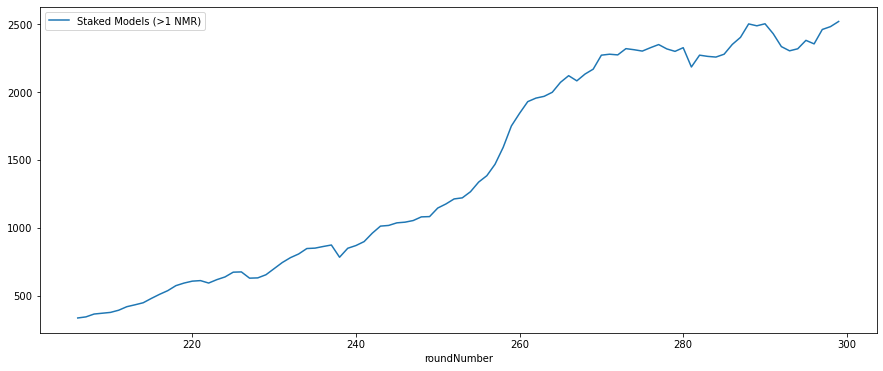

In [106]:
df.set_index('roundNumber')[['staked_model_count']].rename(columns={'staked_model_count':'Staked Models (>1 NMR)'}).plot(figsize=(15,6))